In [1]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Libraries
import Bio
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the pbmc3k dataset
adata = sc.datasets.pbmc3k()

print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata)


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'


In [4]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

# Store the raw data
adata.raw = adata



In [5]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


1872


In [6]:
adata

View of AnnData object with n_obs × n_vars = 2700 × 1872
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimension Reduction

###  GLM-PCA

In [9]:
import rpy2.robjects as robjects

# # Initialize R instance
# r = robjects.r

# # Install BiocManager directly using R
# r('install.packages("BiocManager", repos="http://cran.us.r-project.org")')
# r('BiocManager::install()')

# # Now, try installing glmpca package
# r('BiocManager::install("glmpca")')


In [10]:
# Import rpy2's package module
import rpy2.robjects.packages as rpackages

# Import rpy2's utility module
import rpy2.robjects as ro

# R package names
packnames = ('glmpca', 'BiocManager')

# R package utility function
utils = rpackages.importr('utils')

# Select a mirror for R packages
utils.chooseCRANmirror(ind=1)  # select the first mirror in the list

# R package manager
BiocManager = rpackages.importr('BiocManager')

# Install packages
for pkg in packnames:
    if not rpackages.isinstalled(pkg):
        BiocManager.install(pkg)


In [11]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter

# Activate the pandas2ri interface
pandas2ri.activate()

# Assume 'adata' is your AnnData object from the previous steps
# Convert the AnnData to a DataFrame for the count data
with localconverter(robjects.default_converter + pandas2ri.converter):
    count_data = robjects.conversion.py2rpy(adata.to_df())

# Load the glmpca library in R
robjects.r('library(glmpca)')

# Perform GLM-PCA with the count data
# The number of dimensions L can be adjusted as needed
robjects.r.assign('count_data', count_data)
robjects.r('glmpca_res <- glmpca(count_data, L=10)')

# Retrieve the low-dimensional representation
glmpca_res = robjects.r('glmpca_res$loadings')

# Convert the results back to a pandas DataFrame
with localconverter(robjects.default_converter + pandas2ri.converter):
    glmpca_loadings = robjects.conversion.rpy2py(glmpca_res)

# Deactivate the pandas2ri interface
pandas2ri.deactivate()

# glmpca_loadings now contains the principal components for each cell
print(glmpca_loadings)


                      dim1      dim2      dim3      dim4      dim5      dim6  \
AAACATACAACCAC-1  0.027927 -0.017666 -0.013222  0.009927  0.002890  0.010960   
AAACATTGAGCTAC-1  0.004402 -0.015077  0.021983  0.014355 -0.000643  0.008115   
AAACATTGATCAGC-1  0.016847 -0.017547 -0.015409 -0.009780  0.026942  0.008532   
AAACCGTGCTTCCG-1  0.008861  0.016519  0.009876  0.014993  0.013512 -0.018784   
AAACCGTGTATGCG-1  0.017149  0.002167 -0.030918  0.043063 -0.004248 -0.040316   
...                    ...       ...       ...       ...       ...       ...   
TTTCGAACTCTCAT-1  0.004196  0.023631  0.012420 -0.002101  0.012232  0.010424   
TTTCTACTGAGGCA-1  0.009699 -0.032715  0.017747  0.001326  0.034049  0.010037   
TTTCTACTTCCTCG-1  0.020481 -0.019701  0.057870  0.000210 -0.016717 -0.024165   
TTTGCATGAGAGGC-1  0.011597 -0.025733  0.013690  0.038719  0.014404 -0.031294   
TTTGCATGCCTCAC-1  0.027126 -0.001075  0.003113 -0.024061  0.001309  0.003592   

                      dim7      dim8   

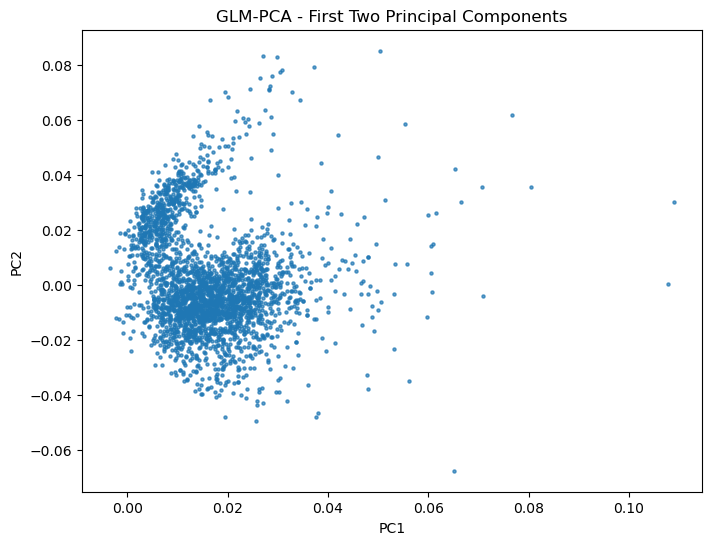

In [12]:
# Extract the first two principal components
pc1 = glmpca_loadings['dim1']
pc2 = glmpca_loadings['dim2']

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, s=5, alpha=0.7)
plt.title('GLM-PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


### ICA

In [18]:
from sklearn.decomposition import FastICA

# Assume 'adata' is your AnnData object and has been preprocessed appropriately
X = adata.X.toarray()  # Convert sparse matrix to dense

# Initialize ICA with the number of components, you can adjust this number
n_components = 10
ica = FastICA(n_components=n_components)

# Fit ICA on the dataset
X_ica = ica.fit_transform(X)

# The result is stored in 'X_ica', which we can add back to the AnnData object
adata.obsm['X_ica'] = X_ica

# Now we can look at the shape of the ICA result
print(X_ica.shape)


(2700, 10)


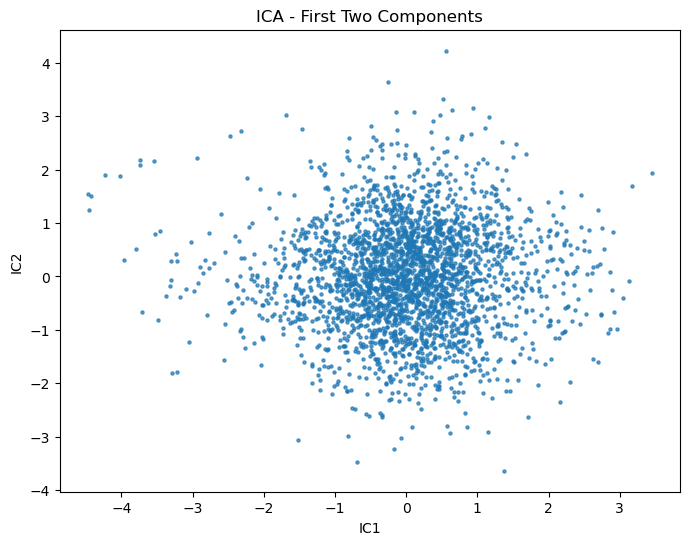

In [19]:
# Extract the first two independent components
ica_comp1 = adata.obsm['X_ica'][:, 0]
ica_comp2 = adata.obsm['X_ica'][:, 1]

# Create a scatter plot of the first two independent components
plt.figure(figsize=(8, 6))
plt.scatter(ica_comp1, ica_comp2, s=5, alpha=0.7)
plt.title('ICA - First Two Components')
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.show()
